In [1]:
%matplotlib inline

In [32]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp

from matplotlib import pyplot as plt
from helpers import (
    draw_edges, get_borderless_fig, pos_spring_layout, signed_layout, get_lcc, signed_normalized_laplacian, flatten,
    pos_adj, neg_adj
)
from viz_helpers import draw_query_result
from stat_helpers import populate_fields

In [146]:
graph = 'epinions'
g = nx.read_gpickle('graphs/{}.pkl'.format(graph))
A = nx.adj_matrix(g, weight='sign')
fog_data = sio.loadmat('outputs/focg-{}.mat'.format(graph))

In [147]:
pos_A = pos_adj(A)
neg_A = neg_adj(A)

# pre-processing

- consider communities with `> ${threshold}` as "good" ones
- only takes those:
  - with exactly **two** good ones
  - the two communities does not overlap
- **future work** should consider "k>2" cases

In [149]:
threshold = 10

In [150]:
fog_comms_keq2 = []
fog_comms_klt2 = []
for i in range(fog_data['X_enumKOCG_cell'].shape[0]):
    r = fog_data['X_enumKOCG_cell'][i][0]
    if r.nnz > threshold * 2:
        r1 = r.tocsc()
        nnz_per = [r1[:, i].nnz for i in range(r.shape[1])]
        nnz_per = np.array(nnz_per)
        sorted_sizes = np.sort(nnz_per)[::-1]
        idx = (nnz_per > threshold)
        # at least two communities with size 10
        if sorted_sizes[1] > threshold:
            if idx.sum() == 2:
                fog_comms_keq2.append(r[:, idx])

In [151]:
rows = []
for comm in fog_comms_keq2:
    C1 = comm[:, 0].nonzero()[0]
    C2 = comm[:, 1].nonzero()[0]    
    if not set(C1).intersection(set(C2)):
        row = dict(
            C1=C1,
            C2=C2,
            size1=len(C1),
            size2=len(C2),        
        )
        rows.append(row)
df = pd.DataFrame.from_records(rows)    

assert df.shape[0] > 0

In [152]:
df = populate_fields(df, pos_A, neg_A)

/home/cloud-user/code/signed/stat_helpers.py:33: RuntimeWarning: invalid value encountered in longlong_scalars
  return 1 - (n_bad_pos + n_bad_neg) / n_total


filtering opp|coh=0 rows


In [153]:
fields_to_show = [ 'size1', 'size2', 'agreement', 'ham', 'coh', 'opp', 'max_posdeg']

In [162]:
def show(idx, **kwargs):
    r = df.loc[idx]
    fig, ax = draw_query_result(g, r['C1'], r['C2'], show_query=False, r=r, **kwargs)
    ax.set_title('agr:{:.2f}, ham:{:.2f}, opp:{:.2f}, coh:{:.2f}, max_posdeg:{:.2f}'.format(
        r['agreement'], r['ham'], r['opp'], r['coh'], r['max_posdeg']
    ))
    
def show_top_k_by(by, k=3):
    rs = df[fields_to_show].sort_values(by=by, ascending=False).head(k)
    print(rs)
    for idx in rs.index:
        print(idx)
        show(idx)
     
    # special treatment to "word" graph
    if graph == 'word':
        for idx in rs.index:
            r = df.iloc[idx]
            print('C1:', ', '.join([g.graph['i2w'][n] for n in r['C1']]))
            print('C2:', ', '.join([g.graph['i2w'][n] for n in r['C2']]))        
            print()        

    size1  size2  agreement       ham       coh       opp  max_posdeg
15     66     11   1.000000  0.047482  0.255711  0.026171    5.090909
12     36     34   0.963636  0.016356  0.035553  0.010621    2.294118
27     16     41   1.000000  0.012646  0.037093  0.007622    2.634146
15
12
27


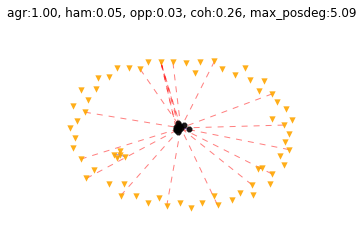

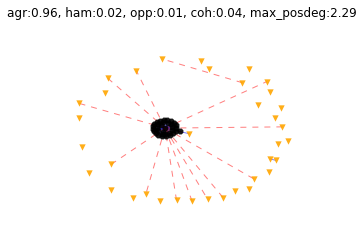

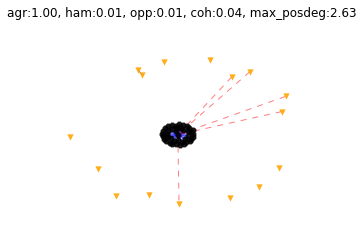

In [163]:
show_top_k_by('ham')

    size1  size2  agreement       ham       coh       opp  max_posdeg
3      31     19        1.0  0.009580  0.080419  0.005093    2.193548
15     66     11        1.0  0.047482  0.255711  0.026171    5.090909
25     24     11        1.0  0.007326  0.110903  0.003788    2.181818
3
15
25


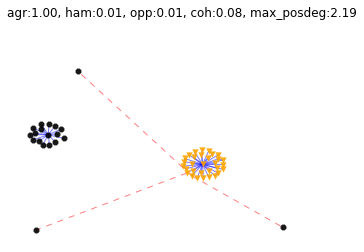

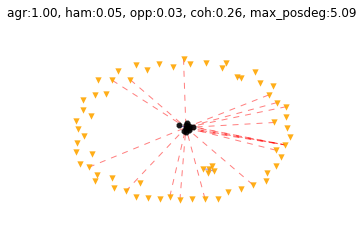

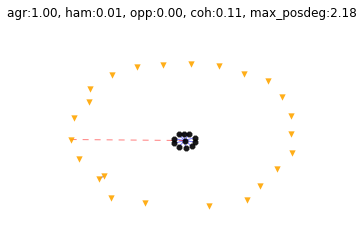

In [164]:
show_top_k_by('agreement')

    size1  size2  agreement       ham       coh       opp  max_posdeg
15     66     11   1.000000  0.047482  0.255711  0.026171    5.090909
12     36     34   0.963636  0.016356  0.035553  0.010621    2.294118
27     16     41   1.000000  0.012646  0.037093  0.007622    2.634146
15
12
27


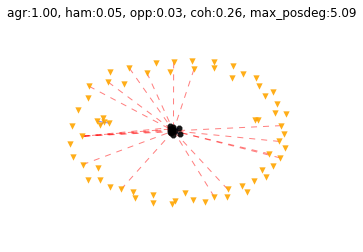

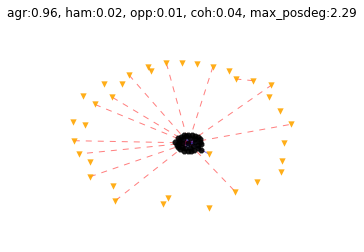

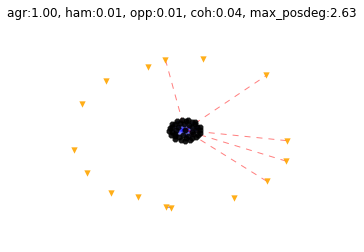

In [165]:
show_top_k_by('opp')